## Go through IWOAI data and correct any errors

### I know that there is at least one case of masks in wrong order

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import h5py

In [3]:
# work out where we are by printing contents of a given path
IWOAI_path = '../data/IWOAI'
print(os.listdir(IWOAI_path))

['valid_copy.tar.gz', 'test', 'test_copy.tar.gz', 'ground-truth', 'valid', 'train', 'train_copy.tar.gz', 'test_gt_copy.zip']


In [6]:
# get list of paths for all images/masks
train_images = glob.glob(IWOAI_path + '/train/*.im')
valid_images = glob.glob(IWOAI_path + '/valid/*.im')
test_images = glob.glob(IWOAI_path + '/test/*.im')

train_masks = glob.glob(IWOAI_path + '/train/*.seg')
valid_masks = glob.glob(IWOAI_path + '/valid/*.seg')
test_masks = glob.glob(IWOAI_path + '/ground-truth/*.npy')

In [7]:
# print counts
print('Number of training images:', len(train_images))
print('Number of training masks:', len(train_masks))
print('Number of validation images:', len(valid_images))
print('Number of validation masks:', len(valid_masks))
print('Number of test images:', len(test_images))
print('Number of test masks:', len(test_masks))

Number of training images: 120
Number of training masks: 120
Number of validation images: 28
Number of validation masks: 28
Number of test images: 28
Number of test masks: 28


In [22]:
# One by one, load images and masks, and check shapes - should be 384, 384, 160
def check_shape(file_path, expected_shape=(384, 384, 160), load_npy=False):
    if load_npy:
        data = np.load(file_path)
    else:
        with h5py.File(file_path, 'r') as f:
            data = np.array(f['data'])

    return data.shape == expected_shape

In [15]:
# Check train images/masks
for i in range(len(train_images)):
    assert check_shape(train_images[i]), f"shape of train image {i} is not (384, 384, 160)"
    assert check_shape(train_masks[i], expected_shape=(384, 384, 160, 6)), f"shape of train mask {i} is not (384, 384, 160, 6)"

In [16]:
#check valid images/masks
for i in range(len(valid_images)):
    assert check_shape(valid_images[i]), f"shape of valid image {i} is not (384, 384, 160)"
    assert check_shape(valid_masks[i], expected_shape=(384, 384, 160, 6)), f"shape of valid mask {i} is not (384, 384, 160, 6)"

In [23]:
# check test images/masks
for i in range(len(test_images)):
    assert check_shape(test_images[i]), f"shape of test image {i} is not (384, 384, 160)"
    assert check_shape(test_masks[i], expected_shape=(384, 384, 160, 4), load_npy=True), f"shape of test mask {i} is not (384, 384, 160, 4)"

In [28]:
# check meniscus masks by combining and checking that there is no overlap
# lateral and medial are at index 4 and 5 of the mask (pre-combined at index 3 in test masks)
def check_masks(mask_paths, test=False):
    for path in mask_paths:
        if test:
            mask = np.load(path)
            meniscus = mask[..., 3]
        else:
            with h5py.File(path, 'r') as f:
                mask = np.array(f['data'])
            meniscus = mask[..., 4] + mask[..., 5]
        if not np.all(meniscus <= 1):
            print(f"meniscus mask {path} has overlap between lateral and medial")

In [29]:
# check train masks
check_masks(train_masks)

meniscus mask ../data/IWOAI/train/train_011_V01.seg has overlap between lateral and medial
meniscus mask ../data/IWOAI/train/train_026_V01.seg has overlap between lateral and medial


In [30]:
# check valid masks
check_masks(valid_masks)

In [31]:
# check test masks
check_masks(test_masks, test=True)

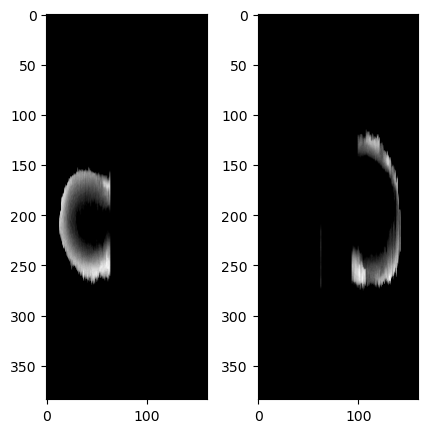

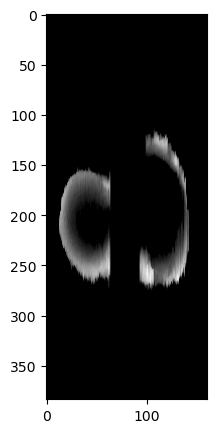

In [62]:
# Let's have a look at the two errors in the train masks
# first, train_011_V01.seg
path = "../data/IWOAI/train/train_011_V01.seg"
with h5py.File(path, 'r') as f:
    mask = np.array(f['data'])

    # plot the two masks
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].imshow(np.sum(mask[..., 4], axis=0), cmap='gray')
    ax[1].imshow(np.sum(mask[..., 5], axis=0), cmap='gray')

    # plot the sum of the two masks
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(np.sum(mask[..., 4] + mask[..., 5], axis=0), cmap='gray')

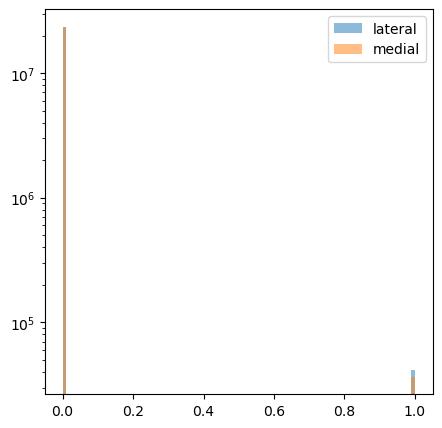

In [63]:
# plot histogram of values in both meniscus masks, making scale logarithmic
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(mask[..., 4].flatten(), bins=100, alpha=0.5, label='lateral', log=True)
ax.hist(mask[..., 5].flatten(), bins=100, alpha=0.5, label='medial', log=True)
ax.legend()
plt.show()

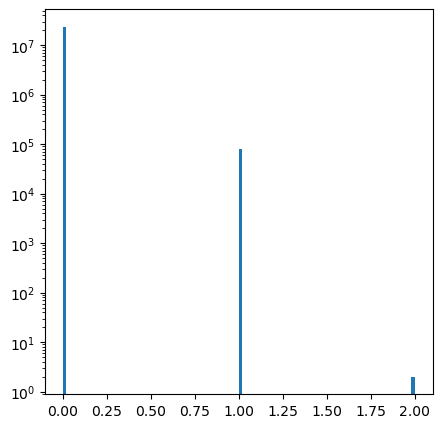

In [64]:
# do same for combined mask
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist((mask[..., 4] + mask[..., 5]).flatten(), bins=100, log=True)
plt.show()

In [46]:
# tiny error, so can ignore it as long as we clip the values to 1

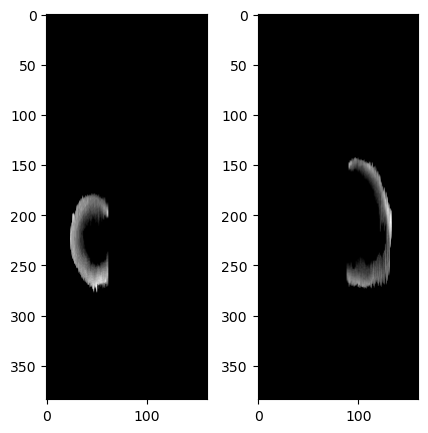

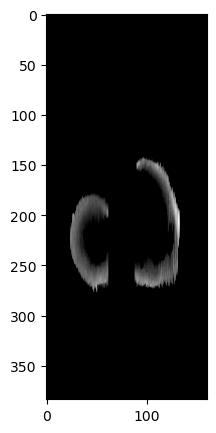

In [61]:
# now look at ../data/IWOAI/train/train_026_V01.seg
path = "../data/IWOAI/train/train_026_V01.seg"
with h5py.File(path, 'r') as f:
    mask = np.array(f['data'])

    # plot the two masks
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].imshow(np.sum(mask[..., 4], axis=0), cmap='gray')
    ax[1].imshow(np.sum(mask[..., 5], axis=0), cmap='gray')

    # plot the sum of the two masks
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(np.sum(mask[..., 4] + mask[..., 5], axis=0), cmap='gray')
    

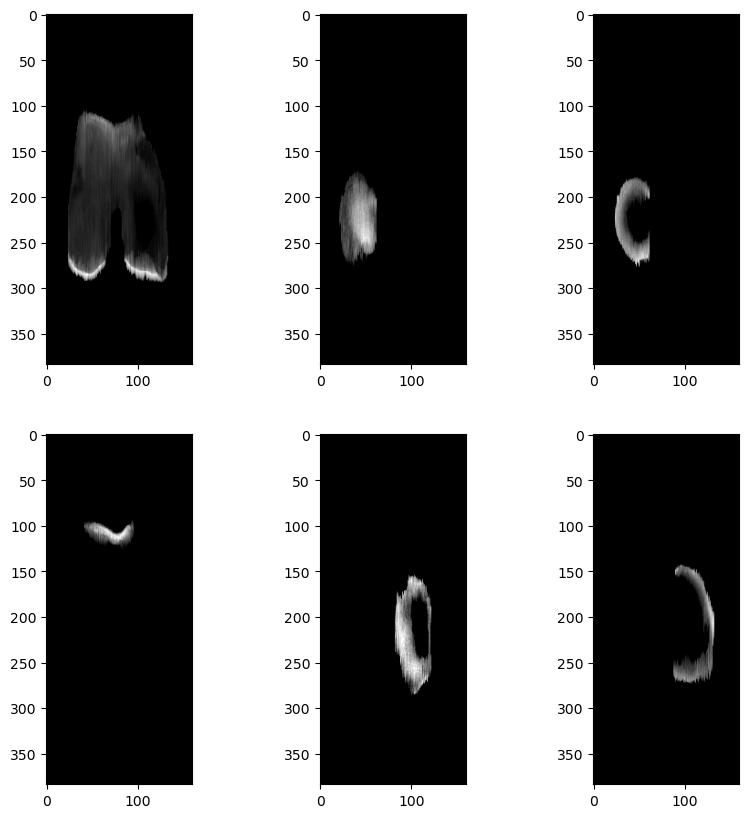

In [59]:
# can see that mask at index 4 is not the meniscus.
# plot all 6 to see where the true mask is
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for i in range(6):
    ax[i//3, i%3].imshow(np.sum(mask[..., i], axis=0), cmap='gray')

In [60]:
# it is at index 2. Swap the two masks at index 2 and 4, and overwrite
new_mask = mask.copy()
new_mask[..., [2, 4]] = new_mask[..., [4, 2]]
with h5py.File(path, 'w') as f:
    f.create_dataset('data', data=new_mask)

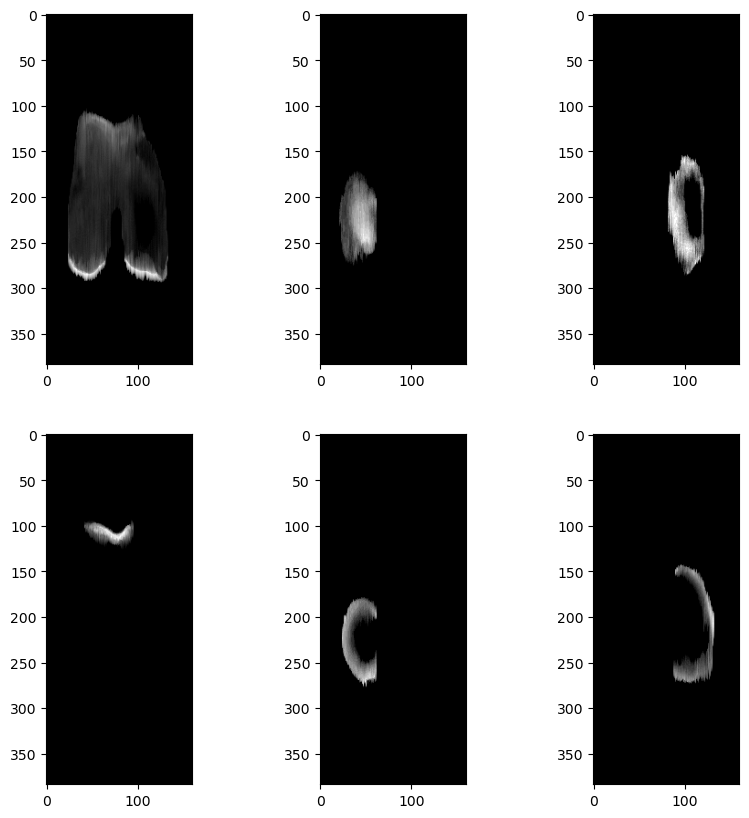

In [56]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for i in range(6):
    ax[i//3, i%3].imshow(np.sum(mask[..., i], axis=0), cmap='gray')